In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# ========================
# Configuration
# ========================
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
learning_rate = 0.0003
epochs = 15
train_dir = r"C:\Users\user\Desktop\MobileNetV3\DATASET\train"
test_dir = r"C:\Users\user\Desktop\MobileNetV3\DATASET\test"

In [6]:
# ========================
# Data Augmentation
# ========================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
# Load dataset from the train directory
full_train_dataset = datasets.ImageFolder(
    root=r"C:\Users\user\Desktop\MobileNetV3\DATASET\train",
    transform=transform_train
)

# Print total number of training images
print(f"✅ Total training images: {len(full_train_dataset)}")

# Print class names
print(f"📂 Class names: {full_train_dataset.classes}")

# Print number of classes
print(f"🔢 Number of classes: {len(full_train_dataset.classes)}")

✅ Total training images: 12271
📂 Class names: ['1', '2', '3', '4', '5', '6', '7']
🔢 Number of classes: 7


In [8]:
# Load dataset from the test directory
test_dataset = datasets.ImageFolder(
    root=r"C:\Users\user\Desktop\MobileNetV3\DATASET\test",
    transform=transform_test
)

# Print total number of images
print(f"✅ Total test images: {len(test_dataset)}")

# Print class names
print(f"📂 Class names: {test_dataset.classes}")

# Print number of classes
print(f"🔢 Number of classes: {len(test_dataset.classes)}")

✅ Total test images: 3068
📂 Class names: ['1', '2', '3', '4', '5', '6', '7']
🔢 Number of classes: 7


In [9]:
# Split train into train/val
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = full_train_dataset.classes

In [11]:
# ========================
# Model Setup
# ========================
model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)

# ========================
# Loss, Optimizer, Scheduler
# ========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
from tqdm import tqdm

def train():
    print("🚀 Training started...\n")
    best_acc = 0.0
    best_model_path = "model.pth"

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        progress_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total

        print(f"✅ Epoch [{epoch+1}/{epochs}] - "
              f"Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        scheduler.step()


In [17]:
# Label mapping
label_mapping = {
    1: 'surprise',
    2: 'fear',
    3: 'disgust',
    4: 'happy',
    5: 'sad',
    6: 'angry',
    7: 'neutral'
}

# ========================
# Evaluation
# ========================
def evaluate():
    model.load_state_dict(torch.load("model.pth"))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Map numeric labels to emotion names
    mapped_preds = [label_mapping[pred + 1] for pred in all_preds]
    mapped_labels = [label_mapping[label + 1] for label in all_labels]

    emotion_names = list(label_mapping.values())

    print("\nClassification Report:\n")
    print(classification_report(mapped_labels, mapped_preds, target_names=emotion_names))

    # Confusion Matrix
    cm = confusion_matrix(mapped_labels, mapped_preds, labels=emotion_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_names, yticklabels=emotion_names, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [14]:
# =============
# Run Training
# =============
train()

🚀 Training started...


Epoch [1/15]


✅ Epoch [1/15] - Loss: 289.1884, Train Acc: 65.82%, Val Acc: 72.05%

Epoch [2/15]


✅ Epoch [2/15] - Loss: 167.5397, Train Acc: 80.73%, Val Acc: 77.47%

Epoch [3/15]


✅ Epoch [3/15] - Loss: 120.3978, Train Acc: 86.25%, Val Acc: 78.24%

Epoch [4/15]


✅ Epoch [4/15] - Loss: 88.5431, Train Acc: 89.84%, Val Acc: 80.28%

Epoch [5/15]


✅ Epoch [5/15] - Loss: 63.9229, Train Acc: 92.81%, Val Acc: 78.00%

Epoch [6/15]


✅ Epoch [6/15] - Loss: 43.4956, Train Acc: 94.72%, Val Acc: 75.47%

Epoch [7/15]


✅ Epoch [7/15] - Loss: 41.4986, Train Acc: 95.27%, Val Acc: 78.69%

Epoch [8/15]


✅ Epoch [8/15] - Loss: 18.5078, Train Acc: 98.13%, Val Acc: 82.27%

Epoch [9/15]


✅ Epoch [9/15] - Loss: 11.5681, Train Acc: 98.98%, Val Acc: 82.11%

Epoch [10/15]


✅ Epoch [10/15] - Loss: 7.8881, Train Acc: 99.39%, Val Acc: 82.84%

Epoch [11/15]


✅ Epoch [11/15] - Loss: 6.3436, Train Acc: 99.43%, Val Acc: 82.15%

Epoch [12/15]


✅ Epoch [12/15] - Loss: 5.0280, Train Acc: 99.60%, Val Acc: 82.07%

Epoch [13/15]


✅ Epoch [13/15] - Loss: 3.6709, Train Acc: 99.70%, Val Acc: 82.44%

Epoch [14/15]


✅ Epoch [14/15] - Loss: 3.3944, Train Acc: 99.75%, Val Acc: 82.56%

Epoch [15/15]


✅ Epoch [15/15] - Loss: 2.4748, Train Acc: 99.87%, Val Acc: 82.60%



Classification Report:

              precision    recall  f1-score   support

    surprise       0.79      0.73      0.76       162
        fear       0.60      0.48      0.53       160
     disgust       0.76      0.53      0.62        74
       happy       0.93      0.93      0.93      1185
         sad       0.79      0.85      0.82       680
       angry       0.80      0.83      0.81       478
     neutral       0.83      0.84      0.83       329

    accuracy                           0.84      3068
   macro avg       0.79      0.74      0.76      3068
weighted avg       0.84      0.84      0.84      3068



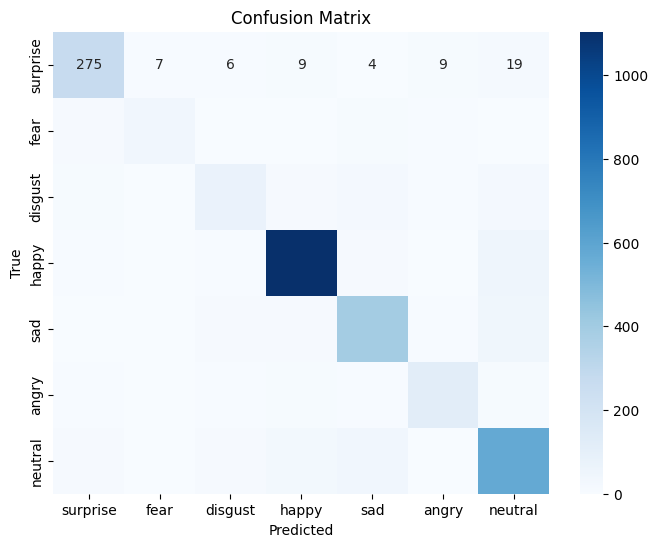

In [18]:
# ===============
# Run Evaluation
# ===============
evaluate()

In [19]:
# =================
# Save Final Model
# =================
torch.save(model.state_dict(), "mobilenetv3_emotion.pth")

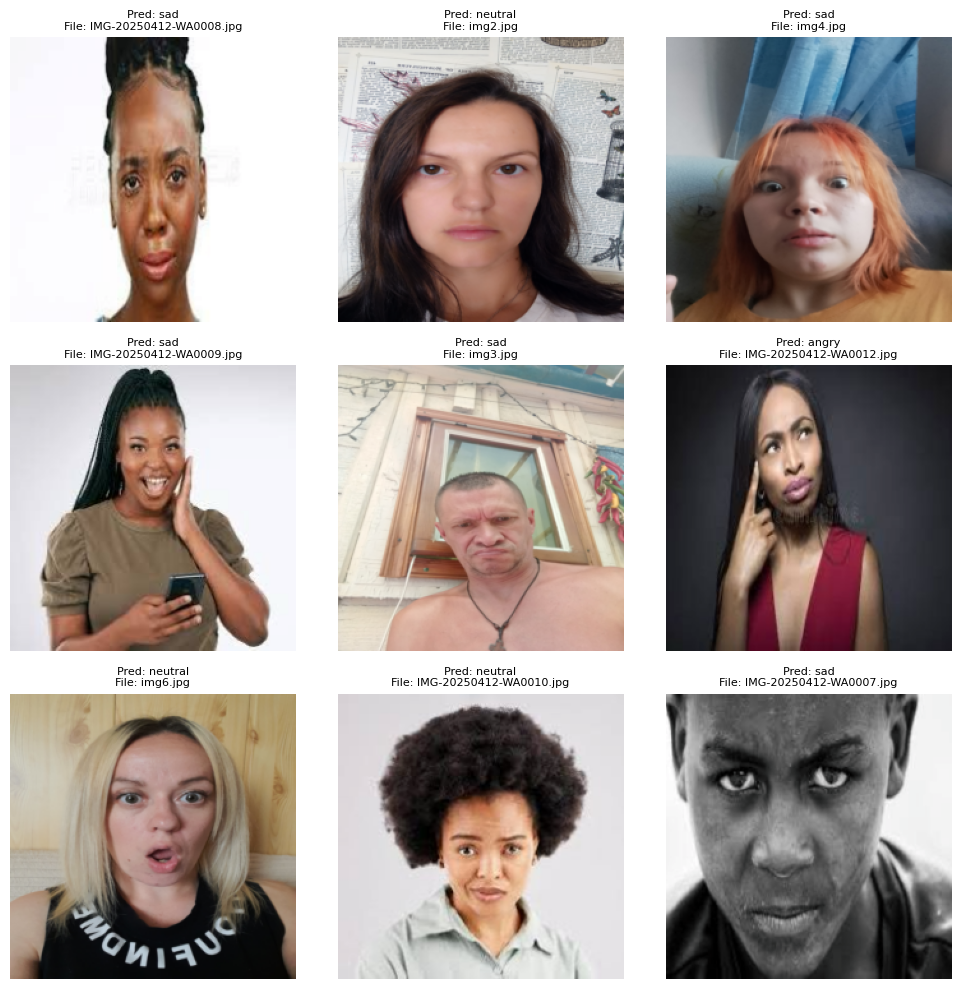

In [24]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# ========================
# Load the Trained Model
# ========================
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 7)  # 7 classes
model.load_state_dict(torch.load("mobilenetv3_emotion.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# ========================
# Image Transform (Same as Test)
# ========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ========================
# Custom Dataset for images without subfolders
# ========================
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)  # return filename instead of label

# ========================
# Load Test Images from Directory
# ========================
test_dir = r"C:\Users\user\Desktop\MobileNetV3\Test"
test_dataset = TestImageDataset(
    image_dir=test_dir,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=9, shuffle=True)  

# Your label map
label_map = {
    0: 'surprise',
    1: 'fear',
    2: 'disgust',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'neutral'
}

# ========================
# Make Predictions and Plot
# ========================
# Get one batch
images, filenames = next(iter(test_loader))

# Move images to device
images = images.to(device)

# Predict
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move everything back to CPU for plotting
images = images.cpu()
predicted = predicted.cpu()

# Denormalize images for visualization
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_tensor = img_tensor * std + mean
    return img_tensor

# Plot
plt.figure(figsize=(10,10))
for i in range(len(images)):
    ax = plt.subplot(3, 3, i+1)
    img = denormalize(images[i]).permute(1, 2, 0).numpy()  # Convert to HWC format
    img = (img * 255).astype("uint8")

    pred_emotion = label_map[predicted[i].item()]

    plt.imshow(img)
    plt.title(f"Pred: {pred_emotion}\nFile: {filenames[i]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()
